# Bounding Boxes

+ Prepare good dataset to train Object localization
+ Prepare methods for drawing bounding boxes
+ Prepare network to predict localization
+ Evaluate the results



In [219]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw, ImageFont
from keras.api.datasets import mnist
from keras.api.utils import to_categorical
import tensorflow as tf

from keras.api.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D


In [220]:
(image_train, label_train), (image_test, label_test) = mnist.load_data()

In [221]:
# read number image, create big 100x100 image, paste number to this bigger canvas
# create bbox localization list
# create datasets train and test after random selection
def create_dataset():
    """
    
    :return: dataset_train, dataset_test
    """
    num_samples = 10000
    new_image_size = (100,100)
    
    images = np.zeros((num_samples, 100, 100, 1), dtype=np.float32)
    labels = np.zeros((num_samples, 10), dtype=np.float32)
    bboxes = np.zeros((num_samples, 4), dtype=np.float32)
    
    for i in range(num_samples):
        digit_image = image_train[i]
        digit_label = label_train[i]
        
        big_image = np.zeros(new_image_size, dtype=np.float32)
        
        max_x = new_image_size[1] - digit_image.shape[1]
        max_y = new_image_size[0] - digit_image.shape[0]
        
        x_offset = np.random.randint(0, max_x)
        y_offset = np.random.randint(0, max_y)
            
        big_image[y_offset:y_offset+28, x_offset:x_offset+28] = digit_image
        # Normalize pixel values od 0-1 and put to images tensor
        images[i, :, :, 0] = big_image / 255.0
        
        labels[i] = to_categorical(digit_label, 10)
        
        x_min = x_offset 
        x_max = x_offset + digit_image.shape[1]
        y_min = y_offset
        y_max = y_offset + digit_image.shape[0]
        
        x_min_norm = x_min / new_image_size[1]
        x_max_norm = x_max / new_image_size[1]
        y_min_norm = y_min / new_image_size[0]
        y_max_norm = y_max / new_image_size[0]
        
        bboxes[i] = [x_min_norm, y_min_norm, x_max_norm, y_max_norm]
        
    # losowe przydzielenie do treningowego i testowego zbioru
    indices = np.arange(num_samples)
    np.random.seed(42)
    np.random.shuffle(indices)
    
    images = images[indices]
    labels = labels[indices]
    bboxes = bboxes[indices]
        
    split_ratio = 0.8
    split_index = int(num_samples * split_ratio)
    
    images_train = images[:split_index]
    labels_train = labels[:split_index]
    bboxes_train = bboxes[:split_index]
    
    images_test = images[split_index:]
    labels_test = labels[split_index:]
    bboxes_test = bboxes[split_index:]
    
    
    
        
    images_tensor_train = tf.convert_to_tensor(images_train, dtype=tf.float32)
    labels_tensor_train = tf.convert_to_tensor(labels_train, dtype=tf.float32)
    bboxes_tensor_train = tf.convert_to_tensor(bboxes_train, dtype=tf.float32)
    dataset_train = tf.data.Dataset.from_tensor_slices((images_tensor_train, (labels_tensor_train, bboxes_tensor_train)))
    
    images_tensor_test = tf.convert_to_tensor(images_test, dtype=tf.float32)
    labels_tensor_test = tf.convert_to_tensor(labels_test, dtype=tf.float32)
    bboxes_tensor_test = tf.convert_to_tensor(bboxes_test, dtype=tf.float32)
    dataset_test = tf.data.Dataset.from_tensor_slices((images_tensor_test, (labels_tensor_test, bboxes_tensor_test)))
    
    return dataset_train, dataset_test

In [222]:
dataset_train, dataset_test = create_dataset()
dataset_train = dataset_train.batch(1000)
dataset_test = dataset_test.batch(100)

In [223]:
for batch in dataset_train.take(1):
    images_batch, (labels_batch, bboxes_batch) = batch
    print("Images batch shape:", images_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    print("Bounding boxes batch shape:", bboxes_batch.shape)
    

Images batch shape: (1000, 100, 100, 1)
Labels batch shape: (1000, 10)
Bounding boxes batch shape: (1000, 4)


# Utilities for bounding box

In [224]:
image_width = 100
image_height = 100
normalized_coordinates = True

def draw_bounding_boxes_array(image, bounding_boxes, label_list):
    """
    
    :return: 
    """
    image = (image * 255).astype(np.uint8)
    image = np.squeeze(image)
    image_pil = PIL.Image.fromarray(image)
    image_rgb = PIL.Image.new('RGBA', image_pil.size)
    image_rgb.paste(image_pil)
    
    draw_bounding_boxes(image_rgb, bounding_boxes, label_list)
    
    return image_rgb
    
def draw_bounding_boxes(image, bounding_boxes, label_list):
    """
    
    :param image: 
    :param bounding_boxes: 
    :param label_list: 
    :return: 
    """
    # Konwersja do tablic NumPy, jeśli są tensorami
    # if tf.is_tensor(bounding_boxes):
    #     bounding_boxes = bounding_boxes.numpy()
    # if tf.is_tensor(label_list):
    #     label_list = label_list.numpy()
    # for bbox, label_one_hot in zip(bounding_boxes, label_list):
    #     label = np.argmax(label_one_hot)
    #     x_min, y_min, x_max, y_max = bbox
    #     draw_bounding_box(image, x_min, y_min, x_max, y_max, label)
    for index, bbox in enumerate(bounding_boxes):
        label = label_list[index]
        x_min, y_min, x_max, y_max = bbox
        draw_bounding_box(image, x_min, y_min, x_max, y_max, label)
        
    label = np.argmax(label_list)
    x_min, y_min, x_max, y_max = bounding_boxes
    draw_bounding_box(image, x_min, y_min, x_max, y_max, label)
    
def draw_bounding_box(image, x_min, y_min, x_max, y_max, label):
    """
    
    :return: 
    """
    drawing = ImageDraw.Draw(image) # draw on selected image

    if normalized_coordinates:
        (left, right, top, bottom) = x_min * image_width, x_max * image_width, y_min * image_height, y_max * image_height
    else:
        (left, right, top, bottom) = x_min, y_min, x_max, y_max
        
    drawing.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)])
    #drawing.text((left, top), str(label), fill='red')
    print(f"label of object: {label}")

    

In [225]:
# bounding_boxes = [[0.34, 0.56, 0.50, 0.89],
#                   [0.1, 0.1, 0.4, 0.5]]
# labels = ['one', 'seven']
# 
# draw_bounding_boxes_array(images_batch[1].numpy(), bboxes_batch[1].numpy(), labels_batch[1].numpy())

In [235]:
# display digits with boxes
def display_digits_with_boxes(image, predictions, true_labels, pred_bboxes, true_bboxes, iou, title):
    
    #fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    #for i in range(4):
    # image_plot = image
    # #predictions = predictions[i].numpy()
    # true_labels = true_labels
    # true_bboxes = true_bboxes
    
    #image_box = draw_bounding_boxes_array(image, true_bboxes, true_labels)
    #img_np = np.array(image_box)
    
    # axs[i].imshow(img_np)
    # axs[i].set_title(title)
    # axs[i].axis('off')

    #plt.show(img_np)
    
    

SyntaxError: incomplete input (170811423.py, line 20)

In [236]:
display_digits_with_boxes(images_batch[0].numpy(), labels_batch[0].numpy(), labels_batch[0].numpy(),
                          np.array([]), bboxes_batch[0].numpy(), np.array([]), "training boxes")

TypeError: cannot unpack non-iterable numpy.float32 object

In [228]:
images_batch[0].numpy()

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [203]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

In [204]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(dataset_train, dataset_test, 10)

IndexError: invalid index to scalar variable.

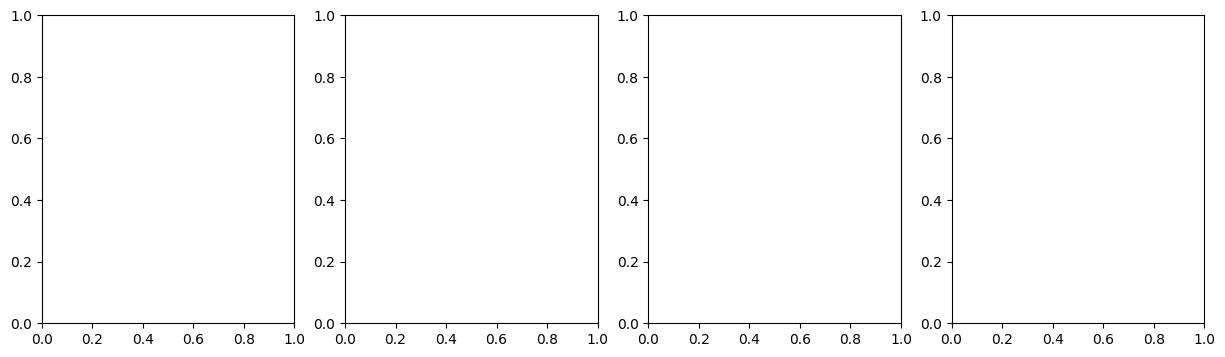

In [205]:
display_digits_with_boxes(training_digits, training_labels, training_labels,
                          np.array([]), training_bboxes, np.array([]), "training boxes")